In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from functools import partial
import optuna
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def fit_and_evaluate(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Model': name,
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    return metrics, confusion_matrix(y_test, y_pred)

# CatBoost

In [ ]:
FILE_PATH = 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'

df = pd.read_csv(FILE_PATH, index_col='id')

In [3]:
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

df['Region_Code'] = df['Region_Code'].astype(str)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(str)

In [4]:
df_sample = df.sample(n=1500000, random_state=42)
X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=1000000, test_size=500000, stratify=y, random_state=42 )

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train: {y_train.value_counts(normalize=True)}")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train: Response
0    0.876795
1    0.123205
Name: proportion, dtype: float64


In [5]:
results = []
conf_matrices = {}

cat_features = ['Region_Code', 'Policy_Sales_Channel']
cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_features]

### RandomizedSearchCV

In [7]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

np.random.seed(42)

param_grid = {
    'iterations': [500, 750, 1000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [3, 4, 5, 6],
    'l2_leaf_reg': [1, 2, 3, 5, 10],
}

n_iter = 15
results = []
conf_matrices = {}

X_train_inner, X_val, y_train_inner, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

best_f1 = -1
best_model = None

start = time.time()

for i in range(n_iter):
    params = {
        'iterations': np.random.choice(param_grid['iterations']),
        'learning_rate': np.random.choice(param_grid['learning_rate']),
        'depth': np.random.choice(param_grid['depth']),
        'l2_leaf_reg': np.random.choice(param_grid['l2_leaf_reg']),
        'scale_pos_weight': scale_pos_weight,
        'verbose': 0,
        'random_state': 42,
        'thread_count': -1,
        'early_stopping_rounds': 50,
        'cat_features': cat_feature_indices,
        'use_best_model': True,
    }

    model = CatBoostClassifier(**params)
    
    model.fit(
        X_train_inner, y_train_inner,
        eval_set=(X_val, y_val),
        verbose=0
    )

    val_pred = model.predict(X_val)
    val_f1 = f1_score(y_val, val_pred)

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model = model
        best_params = params

final_params = best_params.copy()
final_params.pop('use_best_model', None)
final_params.pop('early_stopping_rounds', None)

final_model = CatBoostClassifier(**final_params)
final_model.fit(X_train, y_train, verbose=0)

rand_metrics, rand_cm = fit_and_evaluate(final_model, X_train, X_test, y_train, y_test, "RandomSearchCV")
rand_time = time.time() - start
rand_metrics['Time (sec)'] = rand_time

results.append(rand_metrics)
conf_matrices['RandomSearchCV'] = rand_cm

joblib.dump(final_model, "catboost_random_search_model.pkl")
pd.DataFrame([rand_metrics]).to_csv("catboost_random_search_results.csv", index=False)

### Optuna

In [8]:
X_train_inner, X_val, y_train_inner, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "verbose": False,
        "random_state": 42,
        "thread_count": -1,
        "early_stopping_rounds": 50,
        "use_best_model": True,
        "cat_features": cat_feature_indices,
        "auto_class_weights": "Balanced",
    }

    model = CatBoostClassifier(**params)
    
    model.fit(
        X_train_inner, y_train_inner,
        eval_set=(X_val, y_val),
        verbose=False
    )
    
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

start = time.time()
study = optuna.create_study(direction="maximize", study_name="catboost_optuna")
study.optimize(objective, n_trials=30)
optuna_time = time.time() - start

best_params = study.best_params.copy()

best_params.pop("use_best_model", None)
best_params.pop("early_stopping_rounds", None)

best_params.update({
    "verbose": False,
    "random_state": 42,
    "thread_count": -1,
    "cat_features": cat_feature_indices,
    "auto_class_weights": "Balanced",
})

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train)

optuna_metrics, optuna_cm = fit_and_evaluate(final_model, X_train, X_test, y_train, y_test, "Optuna")
optuna_metrics['Time (sec)'] = optuna_time
results.append(optuna_metrics)
conf_matrices["Optuna"] = optuna_cm

joblib.dump(final_model, "catboost_optuna_model.pkl")
pd.DataFrame([optuna_metrics]).to_csv("catboost_optuna_results.csv", index=False)

[I 2025-12-25 03:39:58,293] A new study created in memory with name: catboost_optuna
[I 2025-12-25 03:42:44,554] Trial 0 finished with value: 0.45368948113866225 and parameters: {'iterations': 830, 'learning_rate': 0.14251691060609345, 'depth': 5, 'l2_leaf_reg': 7.332020527922063, 'random_strength': 0.40368098980663114, 'bagging_temperature': 0.729142723184855}. Best is trial 0 with value: 0.45368948113866225.
[I 2025-12-25 03:45:36,786] Trial 1 finished with value: 0.4547285708587611 and parameters: {'iterations': 744, 'learning_rate': 0.10644647329113578, 'depth': 6, 'l2_leaf_reg': 7.010875232345127, 'random_strength': 4.1533706678181587e-07, 'bagging_temperature': 0.2017885744425144}. Best is trial 1 with value: 0.4547285708587611.
[I 2025-12-25 03:46:05,760] Trial 2 finished with value: 0.4407084089767855 and parameters: {'iterations': 220, 'learning_rate': 0.031098198853222188, 'depth': 3, 'l2_leaf_reg': 1.1672246507183088, 'random_strength': 0.00012498315495525369, 'bagging_tempe

In [9]:
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Time (sec)']]
results_df = results_df.sort_values('F1', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("СРАВНЕНИЕ МОДЕЛЕЙ — ОСНОВНЫЕ МЕТРИКИ")
print("="*80)
print(results_df.to_string(
    formatters={
        'Precision': '{:.4f}'.format,
        'Recall': '{:.4f}'.format,
        'F1': '{:.4f}'.format,
        'ROC-AUC': '{:.4f}'.format,
        'Time (sec)': '{:.1f}'.format
    }
))


СРАВНЕНИЕ МОДЕЛЕЙ — ОСНОВНЫЕ МЕТРИКИ
            Model Precision Recall     F1 ROC-AUC Time (sec)
0          Optuna    0.3046 0.9177 0.4574  0.8781     4170.5
1  RandomSearchCV    0.3019 0.9242 0.4551  0.8780     2365.7


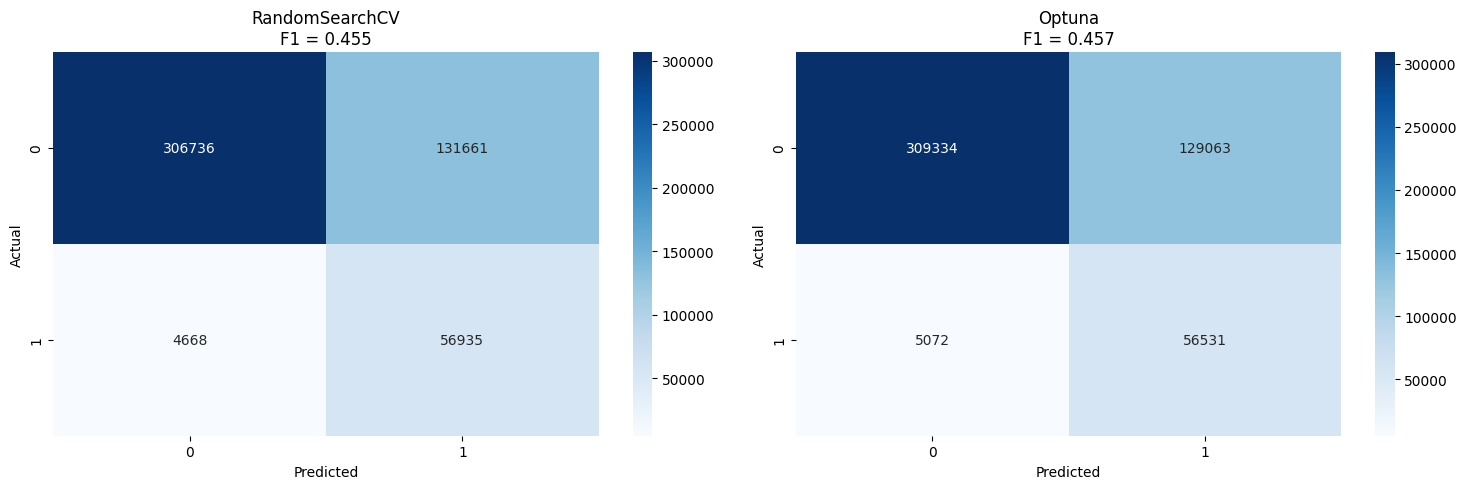

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    f1_val = results_df.loc[results_df['Model'] == name, 'F1'].values[0]
    axes[i].set_title(f'{name}\nF1 = {f1_val:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

for j in range(len(conf_matrices), 2):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Optuna (с побором порогов, валидационной выборкой и early stopping)

In [ ]:
FILE_PATH = 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'

df = pd.read_csv(FILE_PATH, index_col='id')

df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

df['Region_Code'] = df['Region_Code'].astype('int64').astype(str)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int64').astype(str)

df_sample = df.sample(n=2_000_000, random_state=42)
X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=500_000, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    train_size=1_000_000,
    test_size=200_000,
    stratify=y_train_val,
    random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Class balance in train: {y_train.value_counts(normalize=True)}")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cat_features = ['Region_Code', 'Policy_Sales_Channel']

Train: (1000000, 10), Val: (200000, 10), Test: (500000, 10)
Class balance in train: Response
0    0.876881
1    0.123119
Name: proportion, dtype: float64


In [12]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
    }

    model = CatBoostClassifier(
        **params,
        cat_features=cat_features,
        verbose=False,
        random_state=42,
        thread_count=-1,
        early_stopping_rounds=50,
        use_best_model=True,
        auto_class_weights="Balanced"
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)


start = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
optuna_time = time.time() - start

best_params = study.best_trial.params

final_model = CatBoostClassifier(
    **best_params,
    cat_features=cat_features,
    early_stopping_rounds=100,
    use_best_model=True,
    verbose=False,
    random_state=42,
    task_type="CPU",
    auto_class_weights="Balanced"
)

final_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=100
)

y_proba_val = final_model.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.3, 0.8, 0.01)
best_f1, best_th = 0, 0.5

for th in thresholds:
    y_pred = (y_proba_val >= th).astype(int)
    f1 = f1_score(y_val, y_pred)
    if f1 > best_f1:
        best_f1, best_th = f1, th

print(f"Лучший порог (на val): {best_th:.3f}, F1: {best_f1:.4f}")

y_proba_test = final_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_th).astype(int)
test_f1 = f1_score(y_test, y_pred_test)
print(f"F1 на тесте с порогом {best_th:.3f}: {test_f1:.4f}")

artefact = {
    'model': final_model,
    'threshold': best_th,
    'cat_features': cat_features,
    'optuna_time_sec': optuna_time,
    'test_f1': test_f1
}

joblib.dump(artefact, "catboost_optuna_best_model.pkl")

[I 2025-12-25 04:57:43,914] A new study created in memory with name: no-name-341cec14-f2a4-430b-9a6f-4ce32bd644b9
[I 2025-12-25 05:02:14,025] Trial 0 finished with value: 0.45195718986866423 and parameters: {'iterations': 936, 'learning_rate': 0.03708311063993597, 'depth': 7, 'l2_leaf_reg': 8.82864347361485, 'random_strength': 0.2757034178028602, 'bagging_temperature': 0.31535098454968735}. Best is trial 0 with value: 0.45195718986866423.
[I 2025-12-25 05:05:31,082] Trial 1 finished with value: 0.4563832566364568 and parameters: {'iterations': 826, 'learning_rate': 0.17074272417175218, 'depth': 7, 'l2_leaf_reg': 3.7118311833756175, 'random_strength': 7.111615572696635e-08, 'bagging_temperature': 0.3025771482723746}. Best is trial 1 with value: 0.4563832566364568.
[I 2025-12-25 05:07:09,726] Trial 2 finished with value: 0.44588064160263985 and parameters: {'iterations': 728, 'learning_rate': 0.029161859015865307, 'depth': 3, 'l2_leaf_reg': 7.21713894247285, 'random_strength': 0.22534924

0:	learn: 0.6017385	test: 0.6015447	best: 0.6015447 (0)	total: 353ms	remaining: 5m 44s
100:	learn: 0.4030736	test: 0.4035862	best: 0.4035862 (100)	total: 32.5s	remaining: 4m 41s
200:	learn: 0.3981784	test: 0.4003072	best: 0.4003072 (200)	total: 1m 6s	remaining: 4m 15s
300:	learn: 0.3951595	test: 0.3988804	best: 0.3988762 (299)	total: 1m 39s	remaining: 3m 42s
400:	learn: 0.3926708	test: 0.3980703	best: 0.3980703 (400)	total: 2m 12s	remaining: 3m 9s
500:	learn: 0.3903740	test: 0.3976468	best: 0.3976434 (498)	total: 2m 45s	remaining: 2m 36s
600:	learn: 0.3883286	test: 0.3973707	best: 0.3973707 (600)	total: 3m 18s	remaining: 2m 3s
700:	learn: 0.3865204	test: 0.3972653	best: 0.3972523 (695)	total: 3m 51s	remaining: 1m 30s
800:	learn: 0.3847559	test: 0.3971853	best: 0.3971729 (787)	total: 4m 24s	remaining: 57.7s
900:	learn: 0.3829950	test: 0.3973462	best: 0.3971687 (802)	total: 4m 57s	remaining: 24.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3971687487
bestIterati

['catboost_optuna_best_model.pkl']

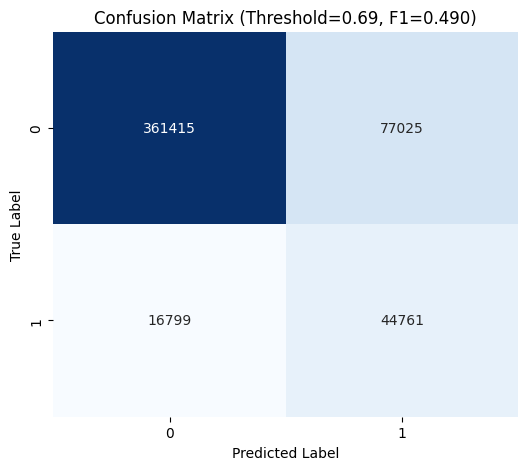

In [13]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Threshold={best_th:.2f}, F1={best_f1:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

                feature  importance
4    Previously_Insured   25.584199
9               Vintage   17.525456
1                   Age   14.125972
7        Annual_Premium   12.342859
8  Policy_Sales_Channel   11.540974
6        Vehicle_Damage    7.794614
3           Region_Code    7.174201
0                Gender    2.041229
5           Vehicle_Age    1.797288
2       Driving_License    0.073207


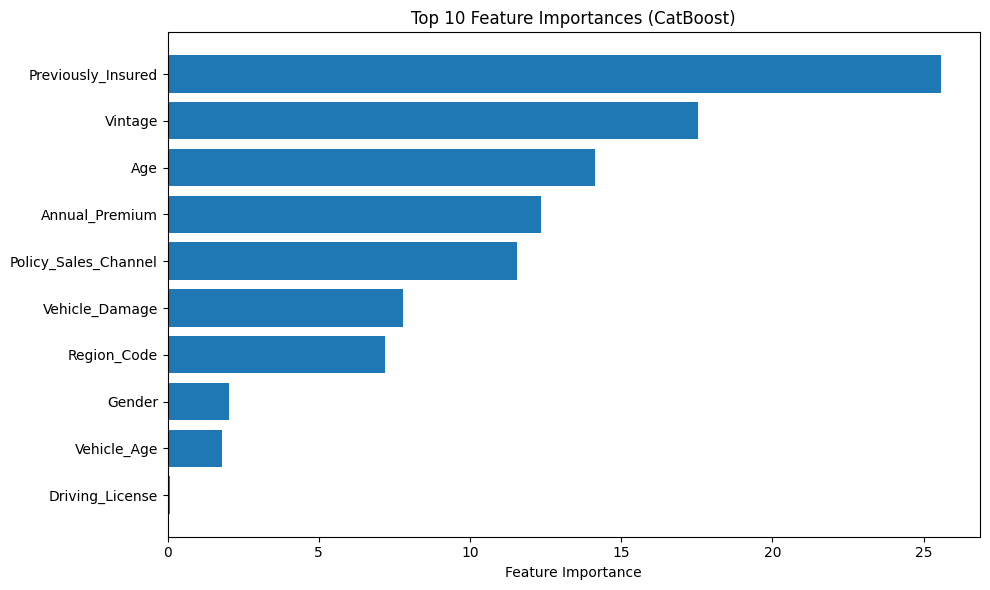

In [14]:
importances = final_model.get_feature_importance()
feature_names = X_train.columns

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False)

print(feat_imp.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'][:10][::-1], feat_imp['importance'][:10][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances (CatBoost)')
plt.tight_layout()
plt.show()

In [ ]:
FILE_PATH = 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'

df = pd.read_csv(FILE_PATH, index_col='id')

df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

df['Region_Code'] = df['Region_Code'].astype('int64').astype(str)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int64').astype(str)

df_sample = df.sample(n=2_000_000, random_state=42)
X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=500_000, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    train_size=1_000_000,
    test_size=200_000,
    stratify=y_train_val,
    random_state=42
)

# Логарифм премии
X_train['Log_Annual_Premium'] = np.log1p(X_train['Annual_Premium'])
X_val['Log_Annual_Premium']   = np.log1p(X_val['Annual_Premium'])
X_test['Log_Annual_Premium']  = np.log1p(X_test['Annual_Premium'])

# Премия на возраст
X_train['Premium_per_Age'] = X_train['Annual_Premium'] / (X_train['Age'] + 1)
X_val['Premium_per_Age']   = X_val['Annual_Premium'] / (X_val['Age'] + 1)
X_test['Premium_per_Age']  = X_test['Annual_Premium'] / (X_test['Age'] + 1)

# Старое авто + ДТП
X_train['Old_Car_With_Damage'] = ((X_train['Vehicle_Age'] == 2) & (X_train['Vehicle_Damage'] == 1)).astype(int)
X_val['Old_Car_With_Damage']   = ((X_val['Vehicle_Age'] == 2) & (X_val['Vehicle_Damage'] == 1)).astype(int)
X_test['Old_Car_With_Damage']  = ((X_test['Vehicle_Age'] == 2) & (X_test['Vehicle_Damage'] == 1)).astype(int)

# Женщина + ДТП
X_train['Female_With_Damage'] = ((X_train['Gender'] == 0) & (X_train['Vehicle_Damage'] == 1)).astype(int)
X_val['Female_With_Damage']   = ((X_val['Gender'] == 0) & (X_val['Vehicle_Damage'] == 1)).astype(int)
X_test['Female_With_Damage']  = ((X_test['Gender'] == 0) & (X_test['Vehicle_Damage'] == 1)).astype(int)

# Новые клиенты по каналу — обучаем ТОЛЬКО на X_train!
channel_new_rate = X_train.groupby('Policy_Sales_Channel')['Previously_Insured'].apply(lambda x: (x == 0).mean())
global_new_rate = (X_train['Previously_Insured'] == 0).mean()

X_train['New_Customer_Rate_By_Channel'] = X_train['Policy_Sales_Channel'].map(channel_new_rate).fillna(global_new_rate)
X_val['New_Customer_Rate_By_Channel']   = X_val['Policy_Sales_Channel'].map(channel_new_rate).fillna(global_new_rate)
X_test['New_Customer_Rate_By_Channel']  = X_test['Policy_Sales_Channel'].map(channel_new_rate).fillna(global_new_rate)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Class balance in train: {y_train.value_counts(normalize=True)}")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cat_features = ['Region_Code', 'Policy_Sales_Channel']

Train: (1000000, 15), Val: (200000, 15), Test: (500000, 15)
Class balance in train: Response
0    0.876881
1    0.123119
Name: proportion, dtype: float64


In [ ]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
    }

    model = CatBoostClassifier(
        **params,
        cat_features=cat_features,
        verbose=False,
        random_state=42,
        thread_count=-1,
        early_stopping_rounds=50,
        use_best_model=True,
        auto_class_weights="Balanced"
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)


start = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
optuna_time = time.time() - start

best_params = study.best_trial.params

final_model = CatBoostClassifier(
    **best_params,
    cat_features=cat_features,
    early_stopping_rounds=100,
    use_best_model=True,
    verbose=False,
    random_state=42,
    task_type="CPU",
    auto_class_weights="Balanced"
)

final_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=100
)

y_proba_val = final_model.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.3, 0.8, 0.01)
best_f1, best_th = 0, 0.5

for th in thresholds:
    y_pred = (y_proba_val >= th).astype(int)
    f1 = f1_score(y_val, y_pred)
    if f1 > best_f1:
        best_f1, best_th = f1, th

print(f"Лучший порог (на val): {best_th:.3f}, F1: {best_f1:.4f}")

y_proba_test = final_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_th).astype(int)
test_f1 = f1_score(y_test, y_pred_test)
print(f"F1 на тесте с порогом {best_th:.3f}: {test_f1:.4f}")

artefact = {
    'model': final_model,
    'threshold': best_th,
    'cat_features': cat_features,
    'optuna_time_sec': optuna_time,
    'test_f1': test_f1
}

joblib.dump(artefact, "catboost_optuna_best_fe_model.pkl")

[I 2025-12-25 06:38:21,706] A new study created in memory with name: no-name-4cb2454b-0e14-422d-bba4-0a95ad289b65
[I 2025-12-25 06:40:07,133] Trial 0 finished with value: 0.4515676966652521 and parameters: {'iterations': 397, 'learning_rate': 0.08831445254304948, 'depth': 6, 'l2_leaf_reg': 8.463837143998276, 'random_strength': 0.001039583824945295, 'bagging_temperature': 0.32185147996507935}. Best is trial 0 with value: 0.4515676966652521.
[I 2025-12-25 06:41:55,467] Trial 1 finished with value: 0.45007917695311345 and parameters: {'iterations': 480, 'learning_rate': 0.08675767065414387, 'depth': 5, 'l2_leaf_reg': 2.7540733226835648, 'random_strength': 2.1352686271283496, 'bagging_temperature': 0.27600918644393957}. Best is trial 0 with value: 0.4515676966652521.
[I 2025-12-25 06:45:08,537] Trial 2 finished with value: 0.4543589130608017 and parameters: {'iterations': 842, 'learning_rate': 0.13625943275747676, 'depth': 5, 'l2_leaf_reg': 6.656228053381693, 'random_strength': 2.098646324

0:	learn: 0.5253440	test: 0.5251700	best: 0.5251700 (0)	total: 366ms	remaining: 6m 5s
100:	learn: 0.3975971	test: 0.4003143	best: 0.4003143 (100)	total: 34.3s	remaining: 5m 4s
200:	learn: 0.3913858	test: 0.3984922	best: 0.3984584 (194)	total: 1m 8s	remaining: 4m 30s
300:	learn: 0.3870056	test: 0.3982936	best: 0.3982434 (292)	total: 1m 42s	remaining: 3m 56s
400:	learn: 0.3829037	test: 0.3982839	best: 0.3982316 (319)	total: 2m 16s	remaining: 3m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3982315908
bestIteration = 319

Shrink model to first 320 iterations.
Лучший порог (на val): 0.690, F1: 0.4891
F1 на тесте с порогом 0.690: 0.4871


['catboost_optuna_best_fi_model.pkl']

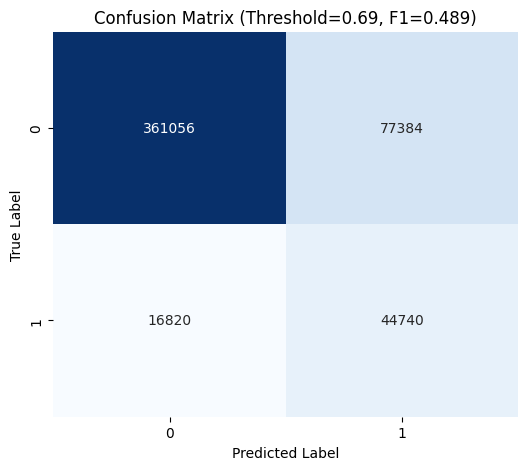

In [17]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Threshold={best_th:.2f}, F1={best_f1:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

                         feature  importance
4             Previously_Insured   28.373678
9                        Vintage   17.602494
1                            Age    9.941087
6                 Vehicle_Damage    8.807075
14  New_Customer_Rate_By_Channel    7.445068
3                    Region_Code    6.873081
7                 Annual_Premium    6.251686
11               Premium_per_Age    6.212512
8           Policy_Sales_Channel    2.889244
10            Log_Annual_Premium    2.651072


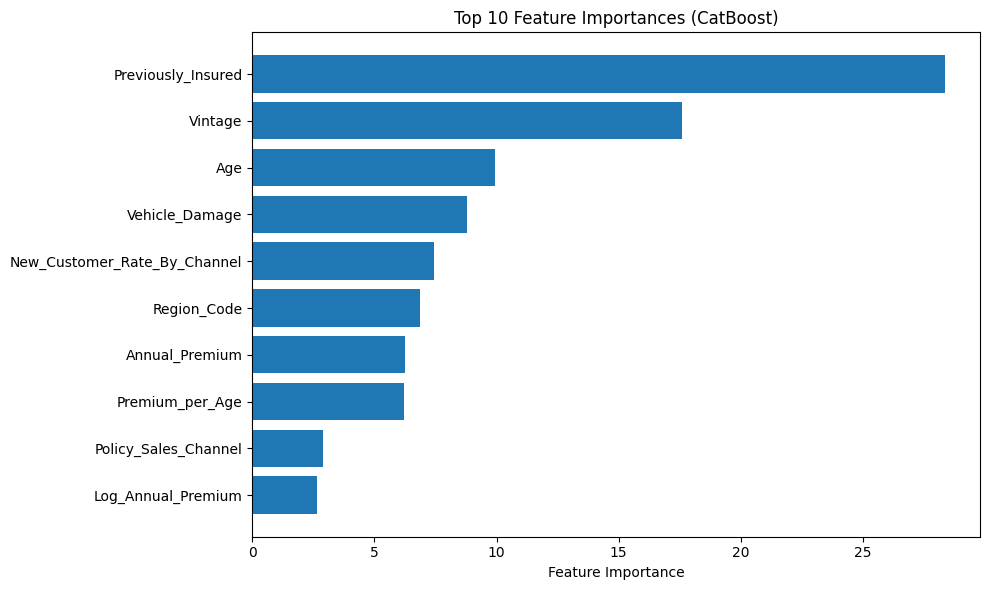

In [ ]:
importances = final_model.get_feature_importance()
feature_names = X_train.columns

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False)

print(feat_imp.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'][:10][::-1], feat_imp['importance'][:10][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances (CatBoost)')
plt.tight_layout()
plt.show()